# Experimento de Indexação Sp-Gist no PostgreSQL

In [36]:
# Imports necessários
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.db_connection import DatabaseConnection, execute_query
from utils.data_generator import BibliotecaDataGenerator
import numpy as np

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

In [37]:
# Inicializa a conexão com o banco de dados
DatabaseConnection.init_connection_pool()

# Cria uma instância do gerador de dados
gerador = BibliotecaDataGenerator(seed=42)

# Limpa o banco de dados para começar do zero
gerador.limpar_banco()
print("Banco de dados limpo e pronto para o experimento.")

Pool de conexão inicializado com sucesso
Limpando o banco de dados...
Banco de dados limpo com sucesso.
Banco de dados limpo e pronto para o experimento.


In [49]:
# Nova consulta SP-GiST sem LIKE (ideal para fulltext + range)
query = """
SELECT id, titulo, dimensao
FROM livros
WHERE dimensao <@ polygon '((0,0),(25,0),(25,35),(0,35),(0,0))';

"""

# Função para executar consulta com EXPLAIN ANALYZE e medir tempo
def executar_consulta_com_tempo(query, collect_stats=True):
    plan_stats = None
    if collect_stats:
        # Versão com EXPLAIN ANALYZE para obter estatísticas
        explain_query = f"EXPLAIN (ANALYZE, BUFFERS, FORMAT JSON) {query}"
        resultado_explain = execute_query(explain_query)

        # Extrair estatísticas
        plan_stats = resultado_explain.values[0][0][0]["Plan"]

    inicio = time.time()
    # Versão simples sem estatísticas
    resultado = execute_query(query)

    fim = time.time()
    tempo_execucao = fim - inicio

    return resultado, tempo_execucao, plan_stats

# Criação de índices SP-GiST
def criar_indices_spgist():
    indices_sql = [
        "CREATE INDEX IF NOT EXISTS idx_livros_dimensao_spgist ON livros USING spgist (dimensao);"
    ]

    print("Criando índices SP-GiST...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices SP-GiST criados com sucesso.")

# Remoção de índices SP-GiST
def remover_indices_spgist():
    indices_sql = [
        "DROP INDEX IF EXISTS idx_livros_dimensao_spgist;"
    ]

    print("Removendo índices SP-GiST...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices SP-GiST removidos com sucesso.")
# Função para extrair informações sobre leituras de disco do plano de execução
def extrair_leituras_de_disco(plan_stats):
    """
    Extrai o número total de leituras de disco (shared_read + local_read) de um plano de execução.
    """
    if not plan_stats:
        return 0
        
    total_reads = 0
    
    # Processar o nó atual
    if 'Shared Read Blocks' in plan_stats:
        total_reads += plan_stats['Shared Read Blocks']
    if 'Local Read Blocks' in plan_stats:
        total_reads += plan_stats['Local Read Blocks']
    
    # Processar recursivamente os nós filhos
    if 'Plans' in plan_stats:
        for subplan in plan_stats['Plans']:
            total_reads += extrair_leituras_de_disco(subplan)
    
    return total_reads


In [50]:
# Parâmetros do experimento
num_iteracoes = 5
registros_por_iteracao = 200000
proporcao_usuarios = 0.00  # 0% dos registros serão usuários
proporcao_livros = 1.0     # 100% dos registros serão livros
proporcao_emprestimos = 0.0  # 0% dos registros serão empréstimos

# Armazenar resultados
resultados_experimento = {
    "total_registros": [],
    "tempo_sem_indices": [],
    "tempo_com_indices": [],
    "num_resultados": [],
    "leituras_sem_indices": [],
    "leituras_com_indices": [],
}

# Registrar total inicial
total_registros = 0

# Loop de experimento: adicionar dados e medir tempo
for i in range(0, num_iteracoes):
    print(f"\n{'=' * 50}")
    print(f"ITERAÇÃO {i + 1}: Adicionando mais {registros_por_iteracao} registros...")
    print(f"{'=' * 50}")

    # Calcular quantos registros de cada tipo adicionar
    adicionar_usuarios = int(registros_por_iteracao * proporcao_usuarios)
    adicionar_livros = int(registros_por_iteracao * proporcao_livros)
    adicionar_emprestimos = registros_por_iteracao - adicionar_usuarios - adicionar_livros

    # Adicionar registros ao banco
    resultado_batch = gerador.popular_banco(
        num_usuarios=adicionar_usuarios,
        num_livros=adicionar_livros,
        num_emprestimos=adicionar_emprestimos,
    )

    # Atualizar total de registros
    registros_adicionados = sum(resultado_batch.values())
    total_registros += registros_adicionados
    resultados_experimento["total_registros"].append(total_registros)

    print(f"\nTotal de registros agora: {total_registros}")

    # 1. Executar consulta SEM índices
    print("\n1. Executando consulta SEM índices...")
    resultado, tempo_sem_indices, stats_sem_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_sem_indices"].append(tempo_sem_indices)
    resultados_experimento["num_resultados"].append(len(resultado))
    print(f"Consulta SEM índices executada em {tempo_sem_indices:.4f} segundos, retornando {len(resultado)} registros.")

    # Extrair leituras de disco
    leituras_sem_indices = extrair_leituras_de_disco(stats_sem_indices)
    resultados_experimento["leituras_sem_indices"].append(leituras_sem_indices)
    print(f"Número de leituras de disco sem índices: {leituras_sem_indices}")

    # 2. Criar índices SP-GiST
    print("\n2. Criando índices SP-GiST...")
    criar_indices_spgist()

    # 3. Executar consulta COM índices
    print("\n3. Executando consulta COM índices SP-GiST...")
    resultado, tempo_com_indices, stats_com_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_com_indices"].append(tempo_com_indices)
    print(f"Consulta COM índices SP-GiST executada em {tempo_com_indices:.4f} segundos, retornando {len(resultado)} registros.")

    # Extrair leituras de disco
    leituras_com_indices = extrair_leituras_de_disco(stats_com_indices)
    resultados_experimento["leituras_com_indices"].append(leituras_com_indices)
    print(f"Número de leituras de disco com índices: {leituras_com_indices}")

    # 4. Remover índices para próxima iteração
    print("\n4. Removendo índices para a próxima iteração...")
    remover_indices_spgist()

print("\nExperimento concluído com sucesso!")



ITERAÇÃO 1: Adicionando mais 200000 registros...
Iniciando populamento do banco de dados...
Esquema criado com sucesso.
Gerando 0 usuários...
Total de 1 usuários inseridos.
Gerando 200000 livros...
Total de 199956 livros inseridos.
Gerando 0 empréstimos...
Total de 0 empréstimos inseridos.
Populamento do banco de dados concluído!

Total de registros agora: 199957

1. Executando consulta SEM índices...
Consulta SEM índices executada em 28.8788 segundos, retornando 1080234 registros.
Número de leituras de disco sem índices: 140018

2. Criando índices SP-GiST...
Criando índices SP-GiST...
Índices SP-GiST criados com sucesso.

3. Executando consulta COM índices SP-GiST...
Consulta COM índices SP-GiST executada em 26.9530 segundos, retornando 1080234 registros.
Número de leituras de disco com índices: 140776

4. Removendo índices para a próxima iteração...
Removendo índices SP-GiST...
Índices SP-GiST removidos com sucesso.

ITERAÇÃO 2: Adicionando mais 200000 registros...
Iniciando populam

Total de 199996 livros inseridos.
Gerando 0 empréstimos...
Total de 0 empréstimos inseridos.
Populamento do banco de dados concluído!

Total de registros agora: 199997

1. Executando consulta SEM índices...
Consulta SEM índices executada em 0.4019 segundos, retornando 475 registros.

2. Criando índices gist...
Criando índices gist...
Índices gist criados com sucesso.

3. Executando consulta COM índices gist...
Consulta COM índices gist executada em 0.0733 segundos, retornando 475 registros.
Número de leituras de disco com índices: 114

4. Removendo índices para a próxima iteração...
Removendo índices gist...
Índices gist removidos com sucesso.

ITERAÇÃO 2: Adicionando mais 200000 registros...
Iniciando populamento do banco de dados...
Esquema criado com sucesso.
Gerando 0 usuários...
Total de 1 usuários inseridos.
Gerando 200000 livros...
Total de 199989 livros inseridos.
Gerando 0 empréstimos...
Total de 0 empréstimos inseridos.
Populamento do banco de dados concluído!

Total de regis

## Resultados do Experimento

Resultados do Experimento:
   Total de Registros  Tempo sem Índices (s)  Tempo com Índices Gist (s)  \
0              199957              28.878759                   26.952976   
1              399913              12.519882                   22.939637   
2              599853              13.133437                   26.781518   
3              799794               5.801236                   18.180426   
4              999728               6.889754                   18.757946   

   Leituras de Disco sem Índices  Leituras de Disco com Índices  \
0                         140018                         140776   
1                         241248                         131137   
2                         253354                         148507   
3                         278806                         166046   
4                         310186                         183196   

   Número de Resultados  Melhoria em Tempo (%)  Redução em Leituras (%)  
0               1080234               6

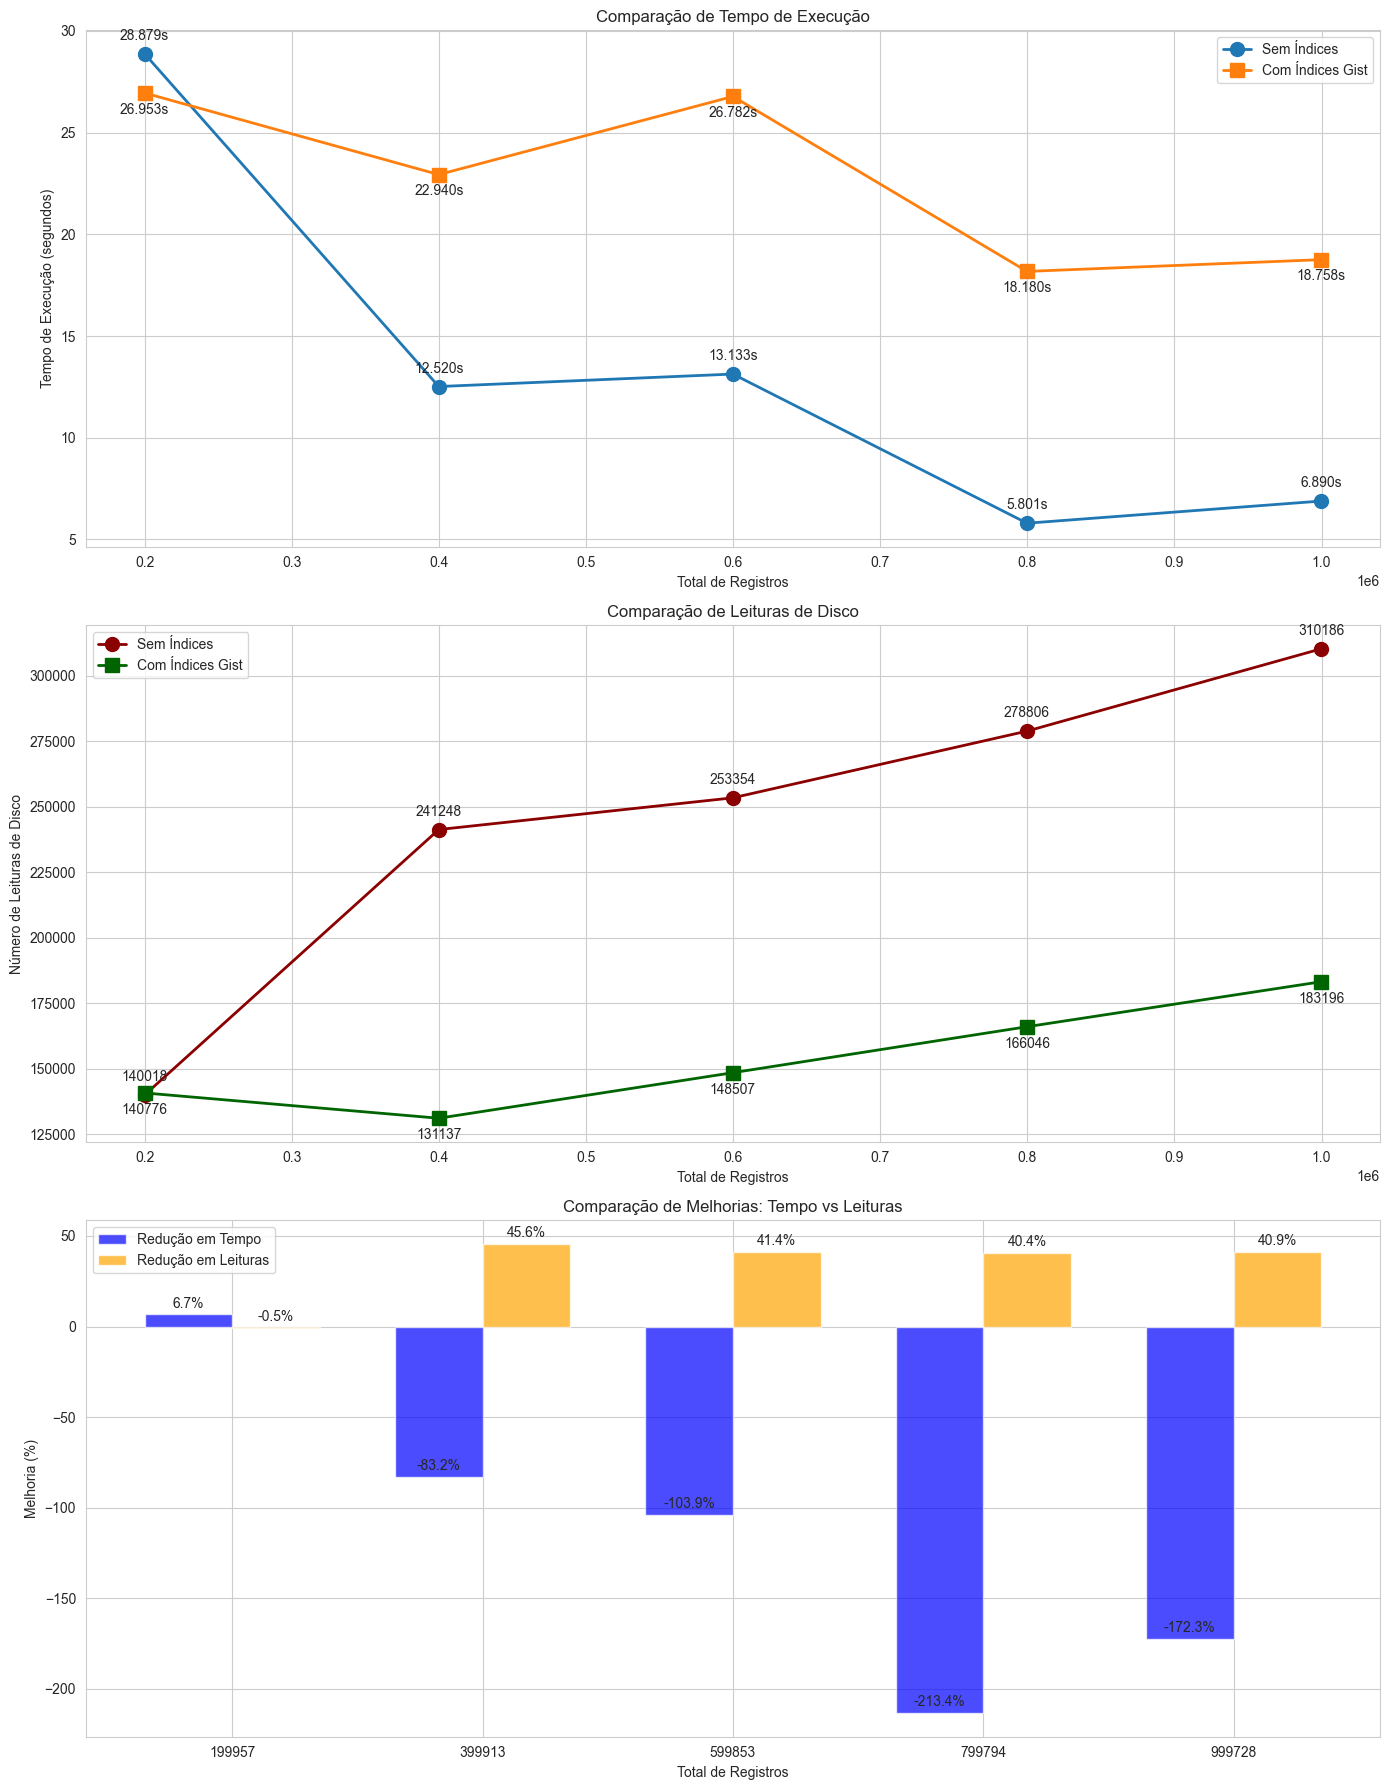

In [51]:
# Criar DataFrame com os resultados
df_resultados = pd.DataFrame({
    'Total de Registros': resultados_experimento['total_registros'],
    'Tempo sem Índices (s)': resultados_experimento['tempo_sem_indices'],
    'Tempo com Índices Gist (s)': resultados_experimento['tempo_com_indices'],
    'Leituras de Disco sem Índices': resultados_experimento['leituras_sem_indices'],
    'Leituras de Disco com Índices': resultados_experimento['leituras_com_indices'],
    'Número de Resultados': resultados_experimento['num_resultados'],
})

# Calcular as melhorias percentuais
df_resultados['Melhoria em Tempo (%)'] = (1 - df_resultados['Tempo com Índices Gist (s)'] / df_resultados['Tempo sem Índices (s)']) * 100
df_resultados['Redução em Leituras (%)'] = (1 - df_resultados['Leituras de Disco com Índices'] / df_resultados['Leituras de Disco sem Índices']) * 100


# Exibir tabela de resultados
print("Resultados do Experimento:")
print(df_resultados)

# Criar três subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18))
# 1. Gráfico de tempo de execução
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo sem Índices (s)'], 'o-', linewidth=2, markersize=10, label='Sem Índices')
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo com Índices Gist (s)'], 's-', linewidth=2, markersize=10, label='Com Índices Gist')
ax1.set_xlabel('Total de Registros')
ax1.set_ylabel('Tempo de Execução (segundos)')
ax1.set_title('Comparação de Tempo de Execução')
ax1.legend()
ax1.grid(True)

# Adicionar rótulos para ambas as linhas do gráfico 1
for i, row in df_resultados.iterrows():
    ax1.annotate(f"{row['Tempo sem Índices (s)']:.3f}s",
                xy=(row['Total de Registros'], row['Tempo sem Índices (s)']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    ax1.annotate(f"{row['Tempo com Índices Gist (s)']:.3f}s",
                xy=(row['Total de Registros'], row['Tempo com Índices Gist (s)']),
                textcoords="offset points",
                xytext=(0,-15),
                ha='center')

# 2. Gráfico de leituras de disco
ax2.plot(df_resultados['Total de Registros'], df_resultados['Leituras de Disco sem Índices'], 'o-', linewidth=2, markersize=10, color='darkred', label='Sem Índices')
ax2.plot(df_resultados['Total de Registros'], df_resultados['Leituras de Disco com Índices'], 's-', linewidth=2, markersize=10, color='darkgreen', label='Com Índices Gist')
ax2.set_xlabel('Total de Registros')
ax2.set_ylabel('Número de Leituras de Disco')
ax2.set_title('Comparação de Leituras de Disco')
ax2.legend()
ax2.grid(True)

# Adicionar rótulos para ambas as linhas do gráfico 2
for i, row in df_resultados.iterrows():
    ax2.annotate(f"{int(row['Leituras de Disco sem Índices'])}",
                xy=(row['Total de Registros'], row['Leituras de Disco sem Índices']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    ax2.annotate(f"{int(row['Leituras de Disco com Índices'])}",
                xy=(row['Total de Registros'], row['Leituras de Disco com Índices']),
                textcoords="offset points",
                xytext=(0,-15),
                ha='center')

# 3. Gráfico de barras para percentual de melhoria (tempo e leituras)
width = 0.35
x = df_resultados['Total de Registros']
x_pos = range(len(x))

ax3.bar(np.array(x_pos) - width/2, df_resultados['Melhoria em Tempo (%)'], width, label='Redução em Tempo', color='blue', alpha=0.7)
ax3.bar(np.array(x_pos) + width/2, df_resultados['Redução em Leituras (%)'], width, label='Redução em Leituras', color='orange', alpha=0.7)
ax3.set_xlabel('Total de Registros')
ax3.set_ylabel('Melhoria (%)')
ax3.set_title('Comparação de Melhorias: Tempo vs Leituras')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(df_resultados['Total de Registros'])
ax3.legend()
ax3.grid(True, axis='y')

# Adicionar valores em cada barra
for i, row in df_resultados.iterrows():
    ax3.annotate(f"{row['Melhoria em Tempo (%)']:.1f}%",
                xy=(i - width/2, row['Melhoria em Tempo (%)']),
                textcoords="offset points",
                xytext=(0,5),
                ha='center')
    ax3.annotate(f"{row['Redução em Leituras (%)']:.1f}%",
                xy=(i + width/2, row['Redução em Leituras (%)']),
                textcoords="offset points",
                xytext=(0,5),
                ha='center')

plt.tight_layout()
plt.show()

In [52]:
# Fechar conexões com o banco de dados ao finalizar
DatabaseConnection.close_all_connections()
print("Conexões com o banco de dados fechadas.")

Conexões com o banco de dados fechadas.
